In [71]:
import torch
import numpy as np
import torchvision
import torch.nn as nn

In [3]:
import os
import matplotlib.pyplot as plt

In [4]:
os.listdir('rps/')

['scissors', 'paper', 'rock']

In [269]:
from torchvision import transforms
from functools import partial

transform_train = transforms.Compose([transforms.RandomCrop(300, padding=4),
                                      transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
                                      torchvision.transforms.Lambda(partial(transforms.functional.adjust_hue, hue_factor=0.05)),
                                      torchvision.transforms.RandomAffine(5),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                     ])

In [270]:
train_dataset = torchvision.datasets.ImageFolder('rps/', transform=transform_train)

In [271]:
train_dataset.imgs[0]

('rps/paper/paper01-000.png', 0)

In [272]:
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [273]:
test_dataset = torchvision.datasets.ImageFolder('test/rps-test-set/', transform=transforms.ToTensor())
batch_size = 64
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False)

In [274]:
train_dataset.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

In [275]:
class_names = {v: k for k, v in train_dataset.class_to_idx.items()}
class_names

{0: 'paper', 1: 'rock', 2: 'scissors'}

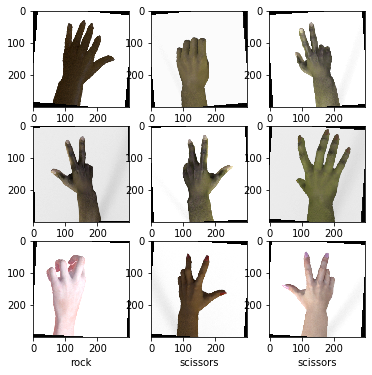

In [290]:
plt.figure(figsize=[6, 6])
for x_batch, y_batch in train_batch_gen:
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.xlabel(class_names[y_batch.data.numpy()[i]])
        plt.imshow(np.transpose(x_batch[i].data.numpy(), (1, 2, 0)))
    break
plt.show()

In [277]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU()):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=kernel_size, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x + inputs)
        return x
    
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, activation=nn.ReLU(), padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [278]:
model = nn.Sequential(Block(in_channels=3, out_channels=48, kernel_size=3, stride=2),

                        ResidualBlock(in_channels=48, out_channels=48, kernel_size=3),
                        nn.MaxPool2d(kernel_size=2, stride=2),

                        Block(in_channels=48, out_channels=96, kernel_size=3, stride=1),
                        nn.MaxPool2d(kernel_size=2, stride=2),

                        ResidualBlock(in_channels=96, out_channels=96, kernel_size=3),
                        nn.MaxPool2d(kernel_size=2, stride=2),

                        Block(in_channels=96, out_channels=192, kernel_size=3, stride=2),
                        nn.MaxPool2d(kernel_size=2, stride=2),

                        ResidualBlock(in_channels=192, out_channels=192, kernel_size=3),
                        nn.MaxPool2d(kernel_size=2, stride=2),

                        Flatten(),
                        nn.Linear(768, 3),
                        nn.LogSoftmax())

In [279]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
compute_loss =  nn.NLLLoss()

In [280]:
from tqdm import tqdm_notebook as tqdm

In [281]:
N_EPOCHS = 20

In [282]:
history = []

test_acc = []
train_acc = []

In [283]:
%%time

model.train(True)

for i in tqdm(range(N_EPOCHS)):
    train_batch_acc = []
    model.train(True)
    for x_batch, y_batch in tqdm(train_batch_gen):
        y_pred = model(x_batch)
        loss = compute_loss(y_pred, y_batch)
        loss.backward()
        opt.step()

        opt.zero_grad()
        history.append(loss)

        model.train(False)
        logits = model(x_batch)
        y_pred = logits.max(1)[1].data.numpy()
        train_batch_acc.append(np.mean(y_batch.data.numpy() == y_pred))
    train_acc.append(np.mean(train_batch_acc))
    
    test_batch_acc = []
    for x_batch, y_batch in (test_batch_gen):
        logits = model(x_batch)
        y_pred = logits.max(1)[1].data.numpy()
        test_batch_acc.append(np.mean(y_batch.data.numpy() == y_pred))
    test_acc.append(np.mean(test_batch_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

In [186]:
test_acc

[[0.0, 0.0625, 1.0, 0.65625, 0.15625, 0.0],
 [0.640625, 0.203125, 0.6875, 0.671875, 0.6875, 0.7115384615384616]]

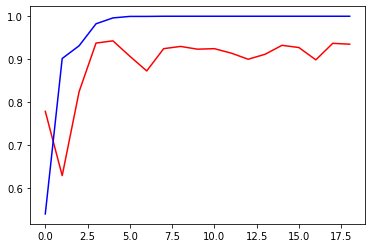

In [284]:
plt.plot(test_acc, c='r')
plt.plot(train_acc, c='b')
plt.show()

In [285]:
test_batch_acc = []
for x_batch, y_batch in tqdm(test_batch_gen):
    logits = model(x_batch)
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch.data.numpy() == y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [286]:
np.mean(test_batch_acc)

0.9316907051282052

In [287]:
torch.save(model, "trained_model")

In [288]:
torch.save(model.state_dict(), 'trained_model_dict')

In [289]:
x_batch

tensor([[[[0.9922, 0.9922, 0.9961,  ..., 0.9686, 0.9569, 0.9686],
          [0.9961, 0.9961, 0.9922,  ..., 0.9686, 0.9647, 0.9608],
          [0.9961, 0.9961, 0.9961,  ..., 0.9725, 0.9647, 0.9647],
          ...,
          [0.9765, 0.9804, 0.9804,  ..., 0.9804, 0.9843, 0.9882],
          [0.9843, 0.9882, 0.9882,  ..., 0.9804, 0.9922, 0.9804],
          [0.9804, 0.9843, 0.9804,  ..., 0.9843, 0.9843, 0.9843]],

         [[0.9922, 0.9922, 0.9961,  ..., 0.9686, 0.9569, 0.9686],
          [0.9961, 0.9961, 0.9922,  ..., 0.9686, 0.9647, 0.9608],
          [0.9961, 0.9961, 0.9961,  ..., 0.9725, 0.9647, 0.9647],
          ...,
          [0.9765, 0.9804, 0.9804,  ..., 0.9804, 0.9843, 0.9882],
          [0.9843, 0.9882, 0.9882,  ..., 0.9804, 0.9922, 0.9804],
          [0.9804, 0.9843, 0.9804,  ..., 0.9843, 0.9843, 0.9843]],

         [[0.9922, 0.9922, 0.9961,  ..., 0.9686, 0.9569, 0.9686],
          [0.9961, 0.9961, 0.9922,  ..., 0.9686, 0.9647, 0.9608],
          [0.9961, 0.9961, 0.9961,  ..., 0